# Cvičení 2

V rámci tohoto cvičení se budeme zabývat zejména metodou konečných diferencí (metodou sítí) v 1D a řešením soustav lineárních rovnic. 

## Průhyb struny 
Připomeňme, že průhyb struny délky $L$ zatížené silou $f$ a uchycené v obou krajních bodech lze popsat obyčejnou diferenciální rovnici
$$-u''(x) = f(x)\qquad \text{pro } x\in (0, L)$$
spolu s okrajovými podmínkami 
$$u(0)=u(L)=0,$$
které určují uchycení struny v krajních bodech intervalu a zajišťují jednoznačnost řešení.

Abychom řešení mohli určit numericky, musíme 
- interval $\left\langle 0, L \right\rangle$ diskretizovat, tzn. rozdělit na konečný počet podintervalů $\left\langle x_0, x_1\right), \left\langle x_1, x_2\right), \ldots\left\langle x_{n-1}, x_n\right)$,
- sestavit matici soustavy $\mathsf{A}$, 
- sestavit vektor pravé strany $\mathbf{f}$, 
- vyřešit soustavu $\mathsf{A}\mathbf{u}=\mathbf{f}$ pro neznámý vektor $\mathbf{u}$, který popisuje průhyb struny ve vnitřních bodech 

Detailní odvození najdete v přednášce.

Vytvoříme si nejdříve pomocné funkce, které se postarají o jednotlivé kroky.

### Diskretizace intervalu

Nejdříve vytvoříme funkci `diskretizuj_interval()`, která bude mít na vstupu délku intervalu $L$ a počet bodů diskretizace. 

Ve funkci vám stačí zavolat jednu z funkcí knihovny NumPy, se kterou jste se již seznámili v předchozím cvičení. 

In [25]:
# ÚKOL: Doplňte definici funkce tak, aby vracela diskretizovaný interval.

import numpy as np

def diskretizuj_interval(L, N):
    interval = np.linspace(0, L, N)
    return interval

In [ ]:
# Otestujte, zda vaše metoda funguje správně. Následující volání by mělo 
# vypsat pole [0. 1. 2. 3. 4.]
x = diskretizuj_interval(4, 5)
print(x)

### Sestavení matice soustavy

Matice soustavy z metody konečných diferencí má následující tvar
$$ \mathsf{A} = \begin{bmatrix} 
2 &  -1 & 0 & 0 & & \cdots & & 0  \\
-1 & 2 & -1 & 0 & & \cdots & & 0 \\
0 & -1 & 2 & -1 & &\cdots & &0 \\
\vdots & & & & \ddots & & &  \\
0 & & & & & -1 & 2 & -1 \\
0 & & & & & & -1 & 2
\end{bmatrix}$$

Jedná se tedy o třídiagonální matici, která má na hlavní diagonále 2 a na diagonálách pod a nad hlavní diagonálou -1.

Vašim dalším úkolem je vytvořit funkci `sestav_matici()`, která bude mít na vstupu dimenzi $N$ a bude vracet odpovídající třídimenzionální matici $\mathsf{A}$ o rozměrech $N\times N$.

Využít můžete funkci `np.diag()`. Ta má dva způsoby využití:
- pokud je na vstupu matice (tzn. 2D pole), vrátí diagonálu této matice (např. `d = diag(A)` vrátí hlavní diagonálu `A`),
- pokud je na vstupu 1D pole, vrátí matici, která má toto pole na $k$-té diagonále (např. `A = diag(d, 1)` umístí na první diagonálu matice `A` vektor `v`).

Vás v tomto případě tedy zajímá druhý způsob použití.

In [ ]:
# Vyzkoušejte si nejprve použití metody np.diag na několika příkladech:

np.set_printoptions(precision=3) # pouze pro lepší přehlednost, omezí počet tisknutých desetinných míst

A = np.random.rand(3, 3)
d0 = np.diag(A)         # uložme hlavní diagonálu matice A do vektoru d0
d1_ = np.diag(A, -1)    # uložme diagonálu pod hlavní diagonálou A do d1_ 
print(A)
print("---------------------")
print(d0)
print("---------------------")
print(d1_)
print("---------------------")

A2 = np.diag(d1_)       # sestaví matici A2, která má na hlavní diagonále vektor d1_
print(A2)

# ÚKOL: Sestavte matici A3, která má na první diagonále nad hlavní diagonálou vektor d0
A3 = np.diag(d0, 1)
print("---------------------")
print(A3)

In [42]:
# ÚKOL: Doplňte definici funkce tak, aby vracela třídiagonální matici metody konečných diferencí
# o rozměrech NxN.
# Metoda np.diag neumí takovou matici sestavit najednou, takže ji budete muset sestavovat
# po částech. 

def sestav_matici(N):
    # Využijte funkce diag a další vhodné funkce pro sestavení potřebných vektorů

    e = np.ones(N)
    e2 = np.ones(N-1)
    A = np.diag(2 * e, 0) + np.diag(-e2, -1) + np.diag(-e2, 1)
    
    return A

In [ ]:
# Ověřte si, že vaše funkce skutečně vrací diagonální matici s 2 na hlavní 
# diagonále a -1 pod a nad hlavní diagonálou.
A = sestav_matici(5)
print(A)

### Sestavení vektoru pravé strany

Nyní sestavíme vektor pravé strany. Ten má v případě metody konečných diferencí a nulových okrajových podmínek tvar
$$
\mathbf{f} = 
\begin{bmatrix}
h^2 f(x_1)\\
h^2 f(x_2)\\
\vdots\\
h^2 f(x_{n-1})\\
h^2 f(x_{n})
\end{bmatrix}.
$$

V našem případě si zvolíme pravou stranu ve tvaru $f(x) = -\sin(x)$.

Vašim úkolem tedy je vytvořit funkci `sestav_f`, která bude mít na vstupu vektor bodů `x` a krok skalár `h` a na výstupu vektor pravé strany vyhodnocený v těchto bodech.

In [53]:
def sestav_f(x, h):
    return -h**2 * np.sin(x)

In [ ]:
# Ověřte, že vaše funkce vrací správné hodnoty při volání nad následujícím polem
x = np.array([0, np.pi/4, np.pi/2, np.pi])
f = sestav_f(x, 0.5)
print(f)

### Řešení

Zbývá dát vše dohromady a sestavit funkci, která bude počítat průhyb struny zatížené danou silou.

Následující funkce má na vstupu délku struny a počet podintervalů, na které interval $\left\langle 0, L\right\rangle$ diskretizován. 


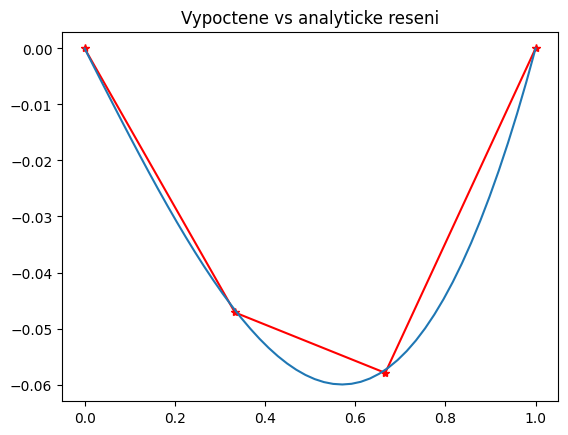

Stisknete libovolnou klavesu


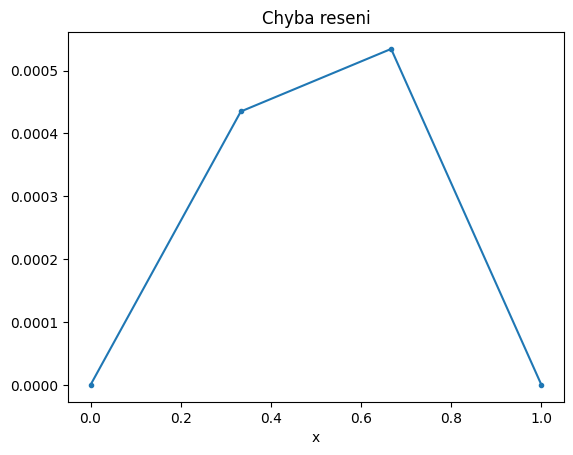

Chyba reseni: 6.89e-04


NameError: name 'b' is not defined

In [59]:
import matplotlib.pyplot as plt

def sit1d(L, N):
    # Řešíme rovnici průhybu struny zatížené danou silou f na intervalu <0, L>:
    # -u''= f, u( 0 ) = 0, u( L ) = 0;   % rovnice struny + okrajové podmínky
    # x z <0,L>                            % interval
    # f = -sin(x)                          % zatížení
    
    ## Disretizace intervalu
    # Nejdříve rozdělíme interval <0, L> na N stejně dlouhých podintevalů, tim
    # vznikne n = N + 1 uzlů sítě { x0, x1, ..., xn }:
    n = N + 1                            # počet uzlů
    h = L / N                            # krok sítě
    # x = np.linspace(0, L, n)             # souřadnice jednotlivých uzlů
    x = diskretizuj_interval(L, n)
    
    ## Sestavení matice A
    # Sestavíme třídiagonální matici A ve tvaru
    # A = [  2 -1  0          ... 0;
    #       -1  2 -1 0        ... 0;
    #        0 -1  2 -1 
    #                  ...
    #                     -1  2 -1;
    #        0 ...           -1  2 ]
    #
    # Matice soustavy ma rozměry (n-2)x(n-2), protože v krajních uzlech řešení 
    # známe:
    # e = np.ones(n-2)
    # e2 = np.ones(n-3)
    # A = np.diag(2 * e, 0) + np.diag(-e2, -1) + np.diag(-e2, 1)
    A = sestav_matici(n-2)
    
    
    ## Vektor pravé strany
    # Vyhodnotíme funkci f ve vnitřních bodech intervalu a sestavíme vektor 
    # pravé strany
    # b = -h**2 * np.sin(x[1:-1])
    f = sestav_f(x[1:-1], h)
    
    ## Numericke reseni
    u_inside = np.linalg.solve(A, f)
    u = np.concatenate(([0], u_inside, [0]))
    
    ## Analyticke reseni
    x_analytic = diskretizuj_interval(L, 50)
    u_analytic = lambda x_analytic: -(np.sin(x_analytic) - np.sin(L)*x_analytic/L)
    
    ## Vykresleni
    plt.figure(1)
    plt.plot(x, u, 'r-*')
    plt.plot(x_analytic, u_analytic(x_analytic))
    plt.title('Vypoctene vs analyticke reseni')
    plt.show()
    
    print('Stisknete libovolnou klavesu')
    input()
    
    plt.figure(2)
    plt.plot(x, abs(u - u_analytic(x)), '.-')
    plt.xlabel('x')
    plt.title('Chyba reseni')
    plt.show()
    print(f'Chyba reseni: {np.linalg.norm(u - u_analytic(x)):3.2e}')
    
    return A, b, u

sit1d(1, 3)

In [ ]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla
A = sp.diags([-e, 2*e, -e], [-1, 0, 1], shape=(n-2, n-2))

In [2]:
!pip install scipy


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!which pip

/opt/homebrew/Caskroom/miniforge/base/bin/pip


In [4]:
!which python

/opt/homebrew/Caskroom/miniforge/base/bin/python
